In [1]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision.transforms as transforms
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

In [4]:
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
        
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        num_channels = 1
        num_classes = 10
        in_channels = num_channels 

        self.model = nn.Sequential(
            # Convolutional layer, from 1x28x28 into 16x14x14 tensor
            nn.Conv2d(num_channels, 16, kernel_size=4, stride=2, padding=1),
            # Batch normalization
            nn.BatchNorm2d(16),
            # Leaky ReLU activation
            nn.LeakyReLU(0.01),
            #nn.Dropout(0.3),
            # Convolutional layer, from 16x14x14 into 32x7x7 tensor
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            # Batch normalization
            nn.BatchNorm2d(32),     
            # Leaky ReLU activation
            nn.LeakyReLU(0.01),
            #nn.Dropout(0.3),
            #nn.Conv2d(32,1,kernel_size=7,stride=1),
            # 32x7x7 -> 1568
            nn.Flatten(start_dim=1),
            nn.Linear(32*7*7, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(0.01),
            nn.Linear(100, 1),

            #nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            # Batch normalization
            #nn.BatchNorm2d(256),     
            # Leaky ReLU activation
            #nn.LeakyReLU(0.01),
  
            # Output layer with sigmoid activation
            #nn.Flatten(),
            #nn.Sigmoid()
        )


    def forward(self, x):
        # convertit le tenseur (batch, 784) en (batch, 1, 28, 28)
        x = x.view(x.size(0), 1, 28, 28)
        #x = x.Reshape(1,28,28)
        #c = self.label_embedding(labels)
        #c = c.view(x.size(0), 10, 28, 28)
        #c = c.Reshape(10,28,28)
        #x = torch.cat([x, c], dim=1)
        output = self.model(x)
        #output = output.view(len(output),1)
        # applatit toutes les dimensions à partir de la n°1 en une seule dimension
        # convertit un tenseur (batch, 1, 1, 1) en un tenseur (batch, 1)
        #output = output.flatten(start_dim=1)
        return output

In [6]:
discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=100, bias=True)
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=100, out_features=1, bias=True)
  )
)


### Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        latent_dim = 100
        num_classes = 10
        input_dim = latent_dim 

        self.model = nn.Sequential(
            # Reshape input into 7x7x256 tensor via a fully connected layer
            #nn.Linear(z_dim,256*7*7),
            #Reshape((256,7,7,)),
            #nn.BatchNorm1d(7*7*256),
            #nn.ReLU(),
            #  100x1x1 -> 128x7x7
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7,stride=1),#,padding=1,output_padding=1)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
            # 128x7x7 -> 64x14x14
            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),  #,padding=1,output_padding=1),
            # Batch normalization
            nn.BatchNorm2d(64),
            # Leaky ReLU activation
            nn.ReLU(),
            # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
            # 64x14x14 -> 32x28x28
            nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),   #,padding=1),
            # Batch normalization
            nn.BatchNorm2d(32),
            # Leaky ReLU activation
            nn.ReLU(),
            # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
            #nn.ConvTranspose2d(64,1,kernel_size=4,stride=2),   #,padding=1,output_padding=1),
            nn.Conv2d(32, 1, kernel_size=5, stride=1, padding=2),
            # Output layer with tanh activation
            nn.Tanh()
        )
        

    def forward(self, x):
        #c = self.label_embedding(labels)
        #x = torch.cat([x,c], 1)
        #output = self.fc(x)
        #output = output.view(-1, 256, 7, 7)
        x=x.view(x.size(0),z_dim,1,1)
        output = self.model(x)
        #output = output.view(-1, 1, 28, 28)
        return output

In [8]:
generator = Generator().to(device)
print(generator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): Tanh()
  )
)


### Training

In [9]:
lr_g = 1e-4
lr_d = 1e-5
lr = 1e-4
num_epochs = 50
loss_function = nn.BCEWithLogitsLoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr,betas = (0.5,0.9))   
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr,betas = (0.5,0.9))

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [11]:
latent_space_samples_plot = torch.randn((batch_size, 100)).to(device=device)

Epoch: 0 Loss D.: 0.7050076723098755
Epoch: 0 Loss G.: 0.7833021879196167


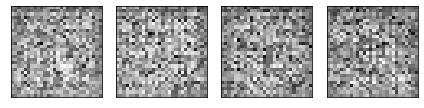

Epoch: 1 Loss D.: 0.5399997234344482
Epoch: 1 Loss G.: 0.9442138075828552


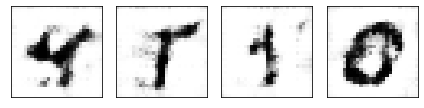

Epoch: 2 Loss D.: 0.6315109729766846
Epoch: 2 Loss G.: 0.8905417919158936


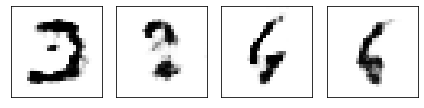

Epoch: 3 Loss D.: 0.5003377199172974
Epoch: 3 Loss G.: 0.9702636003494263


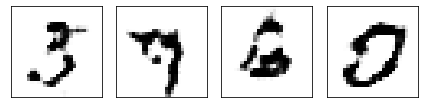

Epoch: 4 Loss D.: 0.5452855825424194
Epoch: 4 Loss G.: 1.0331857204437256


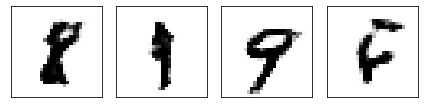

Epoch: 5 Loss D.: 0.5242117643356323
Epoch: 5 Loss G.: 0.9515000581741333


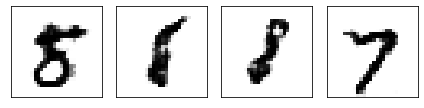

Epoch: 6 Loss D.: 0.698103129863739
Epoch: 6 Loss G.: 0.8420536518096924


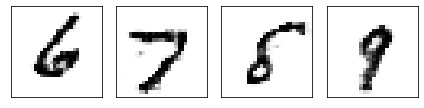

Epoch: 7 Loss D.: 0.5570287704467773
Epoch: 7 Loss G.: 0.965752363204956


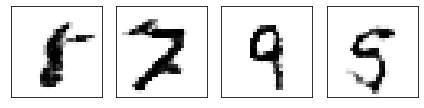

Epoch: 8 Loss D.: 0.5016067028045654
Epoch: 8 Loss G.: 0.9943754076957703


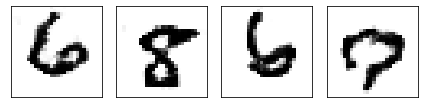

Epoch: 9 Loss D.: 0.5442160367965698
Epoch: 9 Loss G.: 1.2742211818695068


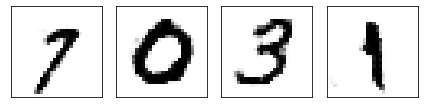

Epoch: 10 Loss D.: 0.6478818655014038
Epoch: 10 Loss G.: 0.7799781560897827


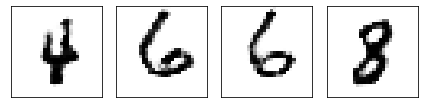

Epoch: 11 Loss D.: 0.4828492999076843
Epoch: 11 Loss G.: 1.315850019454956


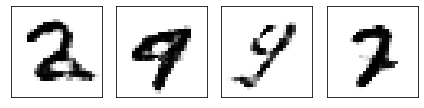

Epoch: 12 Loss D.: 0.39317405223846436
Epoch: 12 Loss G.: 1.3349676132202148


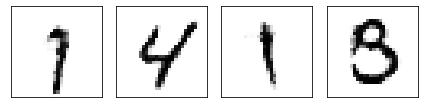

Epoch: 13 Loss D.: 0.45369067788124084
Epoch: 13 Loss G.: 1.3351564407348633


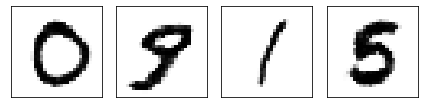

Epoch: 14 Loss D.: 0.5783730745315552
Epoch: 14 Loss G.: 0.9650574922561646


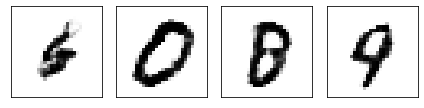

Epoch: 15 Loss D.: 0.5682836771011353
Epoch: 15 Loss G.: 0.987820029258728


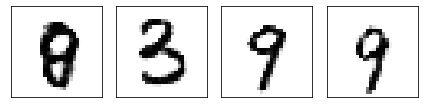

Epoch: 16 Loss D.: 0.6287362575531006
Epoch: 16 Loss G.: 0.9048247337341309


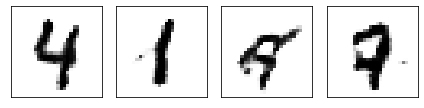

Epoch: 17 Loss D.: 0.5496276617050171
Epoch: 17 Loss G.: 1.1177258491516113


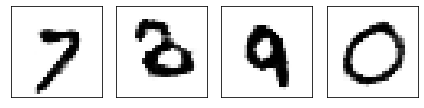

Epoch: 18 Loss D.: 0.5954456925392151
Epoch: 18 Loss G.: 1.105445146560669


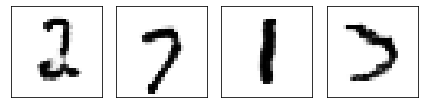

Epoch: 19 Loss D.: 0.5120999217033386
Epoch: 19 Loss G.: 1.2657532691955566


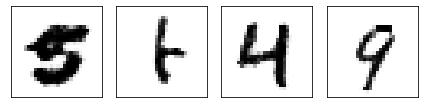

Epoch: 20 Loss D.: 0.5189991593360901
Epoch: 20 Loss G.: 1.1502740383148193


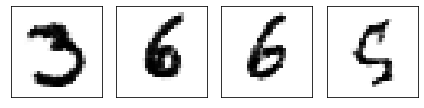

Epoch: 21 Loss D.: 0.5698732137680054
Epoch: 21 Loss G.: 1.196203589439392


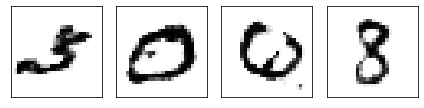

Epoch: 22 Loss D.: 0.5414053201675415
Epoch: 22 Loss G.: 1.0962984561920166


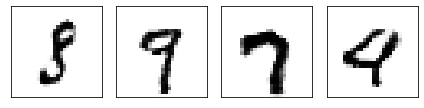

Epoch: 23 Loss D.: 0.5043150186538696
Epoch: 23 Loss G.: 1.2379021644592285


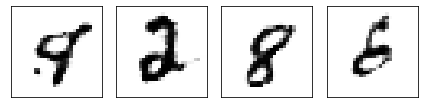

Epoch: 24 Loss D.: 0.6054046154022217
Epoch: 24 Loss G.: 1.092927098274231


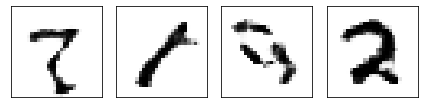

Epoch: 25 Loss D.: 0.5218830704689026
Epoch: 25 Loss G.: 1.1771984100341797


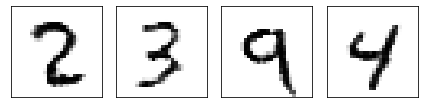

Epoch: 26 Loss D.: 0.5053374171257019
Epoch: 26 Loss G.: 1.1022666692733765


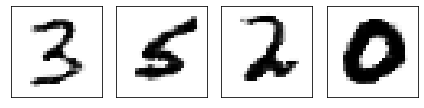

Epoch: 27 Loss D.: 0.503375768661499
Epoch: 27 Loss G.: 1.3549631834030151


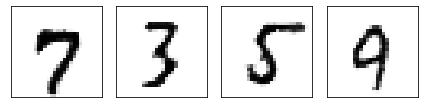

Epoch: 28 Loss D.: 0.5979738831520081
Epoch: 28 Loss G.: 1.1452312469482422


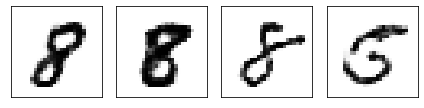

Epoch: 29 Loss D.: 0.5185898542404175
Epoch: 29 Loss G.: 1.1593053340911865


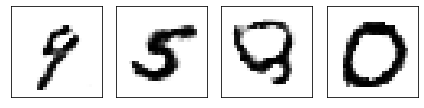

Epoch: 30 Loss D.: 0.6340337991714478
Epoch: 30 Loss G.: 1.0337321758270264


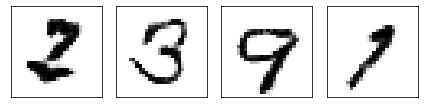

Epoch: 31 Loss D.: 0.44035637378692627
Epoch: 31 Loss G.: 1.3395460844039917


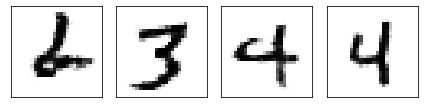

Epoch: 32 Loss D.: 0.49873030185699463
Epoch: 32 Loss G.: 1.2891796827316284


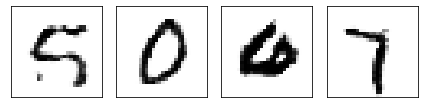

Epoch: 33 Loss D.: 0.47363096475601196
Epoch: 33 Loss G.: 1.2582037448883057


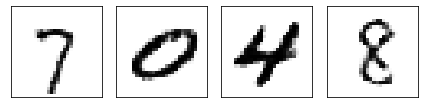

Epoch: 34 Loss D.: 0.499287873506546
Epoch: 34 Loss G.: 1.109320878982544


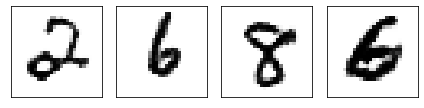

Epoch: 35 Loss D.: 0.5317263603210449
Epoch: 35 Loss G.: 1.148566484451294


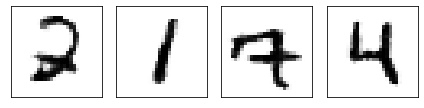

Epoch: 36 Loss D.: 0.5351574420928955
Epoch: 36 Loss G.: 1.3527681827545166


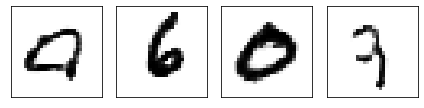

Epoch: 37 Loss D.: 0.5449857711791992
Epoch: 37 Loss G.: 1.1077582836151123


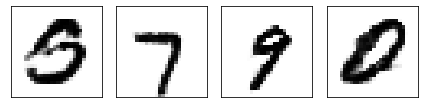

Epoch: 38 Loss D.: 0.47067326307296753
Epoch: 38 Loss G.: 1.3031466007232666


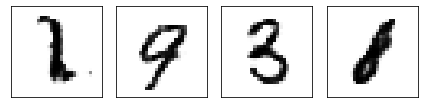

Epoch: 39 Loss D.: 0.4479113817214966
Epoch: 39 Loss G.: 1.4899132251739502


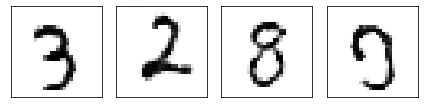

Epoch: 40 Loss D.: 0.5027247667312622
Epoch: 40 Loss G.: 1.3937444686889648


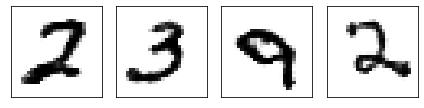

Epoch: 41 Loss D.: 0.45194852352142334
Epoch: 41 Loss G.: 1.383535385131836


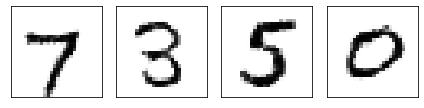

Epoch: 42 Loss D.: 0.620532751083374
Epoch: 42 Loss G.: 1.0274360179901123


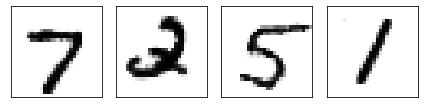

Epoch: 43 Loss D.: 0.4511955678462982
Epoch: 43 Loss G.: 1.3375051021575928


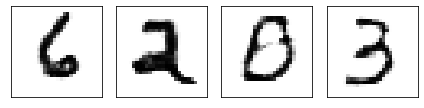

Epoch: 44 Loss D.: 0.5194616317749023
Epoch: 44 Loss G.: 1.3988518714904785


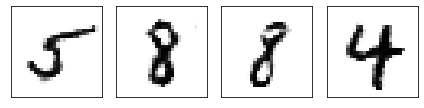

Epoch: 45 Loss D.: 0.5126687288284302
Epoch: 45 Loss G.: 1.2155170440673828


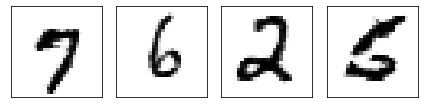

Epoch: 46 Loss D.: 0.5840253233909607
Epoch: 46 Loss G.: 1.2302418947219849


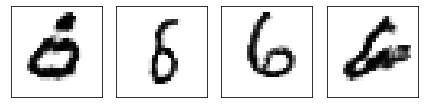

Epoch: 47 Loss D.: 0.453624963760376
Epoch: 47 Loss G.: 1.5408694744110107


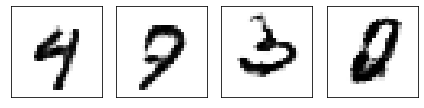

Epoch: 48 Loss D.: 0.581400990486145
Epoch: 48 Loss G.: 1.0097531080245972


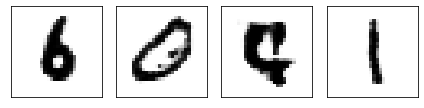

In [ ]:
import os

# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in range(num_epochs):
      for n, (real_samples, mnist_labels) in enumerate(train_loader):
          ##############################
          ## update the discriminator
          ##############################
          batch_size = real_samples.size(0)
          noise = torch.randn((batch_size, 100))
          noise = noise.to(device)

          real_samples = real_samples.to(device)
          mnist_labels = mnist_labels.to(device)
          
          # zero the parameter gradients
          optimizer_discriminator.zero_grad()
          
          # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
          fake_samples = generator(noise)
          
          # forward du discriminator

          disc_real_output = discriminator(real_samples)
          #print(fake_samples.size())
          disc_fake_output = discriminator(fake_samples.detach()) # on detach fake_samples, car on n'a pas 
                                                                                # besoin d'avoir accès au gradient du generateur
          
          # calculate the loss for the discriminator
          loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
          
          # calculate the gradient for the discriminator
          loss_discriminator.backward()  
          
          # update the discriminator first
          optimizer_discriminator.step()
          
          ##############################
          ## update the Generator
          ##############################
          
          # zero the parameter gradients
          optimizer_generator.zero_grad()

          # forward du discriminator
          # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
          #print(fake_samples.size())
          disc_fake_output = discriminator(fake_samples)
          
          # calculate the loss for the generator
          loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
          
          # calculate the gradient for the discriminator
          loss_generator.backward() 
          
          # update the generator
          optimizer_generator.step()

          # Show loss
          if n == batch_size - 1:
              print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
              print(f"Epoch: {epoch} Loss G.: {loss_generator}")
              
              latent_space_samples = torch.randn(batch_size, 100).to(device=device)

              generated_samples = generator(latent_space_samples)
              generated_samples = generated_samples.cpu().detach()

              plt.figure()
              for i in range(4):
                  ax = plt.subplot(1, 4, i+1)
                  plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                  plt.xticks([])
                  plt.yticks([])
              plt.tight_layout()
              plt.show()

On change de loss -> LSGAN 